# Benchmark of data files with the Ministry of Information Technologies and Communications "100 Mil programadores" data.

Data about the "100 mil programadores" program, each row is a students or an applicant.

Details of the data can be readed in [Misión TIC 100 mil programadores](https://www.datos.gov.co/Ciencia-Tecnolog-a-e-Innovaci-n/Misi-n-TIC-2020-100-mil-programadores/2emd-i46m)

- Import the libraries to make the benchmark

In [42]:
#General imports
import requests
import json
import timeit
import os
import random

#Parquet imports
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

#Data management imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

- Setup and download data

Set "download_data" to True if you want download the data from [Datos Gov](www.datos.gov.co) page directly.

The URL contain the query param to get all the data using the Socrata API (SODA API).
Details about the use of that API can be viewed in:

[SODA endpoints](https://dev.socrata.com/docs/endpoints.html)
[SODA Pagination](https://dev.socrata.com/docs/paging.html)

In [44]:
url_mintic2020_100mil = "https://www.datos.gov.co/resource/2emd-i46m.json?$limit=135000"

response = requests.get(url = url_mintic2020_100mil)

if response.status_code != 200:
    print('An error was founded, try again')
else:
    data = response.json()

Define auxiliary functions to store and analyze data.

In [88]:
def store_results(json_value, df_value, parquet_value):
  results = {
  "json" : json_value,
  "df-pickle": df_value,
  "parquet": parquet_value,
  }
  return results

def analyze_dict(dict):
  max_size = max(dict, key=dict.get)
  min_size = min(dict, key=dict.get)
  percentage= 100 - (dict[min_size]*100/dict[max_size])
  return max_size, min_size, percentage

def plot_dict(data, label_x, label_y, title):
  keys = list(data.keys())
  vals = [float(data[k]) for k in keys]
  fig = sns.barplot(x=keys, y=vals)
  fig.set(xlabel=label_x, ylabel=label_y, title=title)
  plt.show()

## Save the data

Function declaration for each file

In [45]:
#Load df as "colums"
df = pd.DataFrame.from_records(data)
df.shape

(134563, 15)

In [46]:
def save_json(data):
    with open('./raw_data.json', 'w') as f:
        json.dump(data, f)
        
def save_df(df):
    df.to_pickle("./raw_data.pkl")
    
def save_parquet(df):
    table = pa.Table.from_pandas(df)
    pq.write_table(table, './data_mintic.parquet')

In [52]:
%%timeit -o
save_json(data)

2.3 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2.3 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [55]:
time_save_json = _
print(time_save_json.average)

2.3019347349992523


In [56]:
%%timeit -o
save_df(df)

754 ms ± 9.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 754 ms ± 9.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [57]:
time_save_df = _
print(time_save_df.average)

0.7540899988546569


In [58]:
%%timeit -o
save_parquet(df)

250 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 250 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [59]:
time_save_parquet = _
print(time_save_parquet.average)

0.25026300628295367


In [89]:
times = store_results(time_save_json.average,time_save_df.average,time_save_parquet.average)
max_time, min_time, percentage_time = analyze_dict(times)

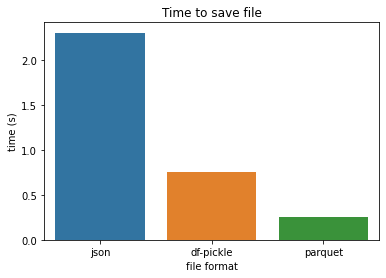

In [90]:
plot_dict(times,"file format", "time (s)", "Time to save file")

In [91]:
print(f'The {min_time} format is {"{:.2f}".format(percentage_time)}% faster than the {max_time} format.')

The parquet format is 89.13% faster than the json format.


## Read file

In [64]:
def read_json():
    with open('raw_data.json') as f:
        json_data = json.load(f)
    return json_data

In [66]:
%%timeit -o
read_json()

615 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 615 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [67]:
time_read_json = _
print(time_read_json.average)

0.6153517188566704


In [68]:
%%timeit -o
pd.read_pickle("./raw_data.pkl")

279 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 279 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [72]:
time_read_pickle = _
print(time_read_pickle.average)

0.27906008571153507


In [73]:
%%timeit -o
pq.read_table('./data_mintic.parquet')

22.9 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 22.9 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [74]:
time_read_parquet = _
print(time_read_parquet.average)

0.0228554441853443


In [92]:
times_read = store_results(time_read_json.average*1000,time_read_pickle.average*1000,time_read_parquet.average*1000)
max_time_read, min_time_read, percentage_time_read = analyze_dict(times_read)

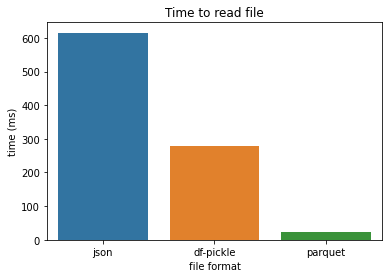

In [93]:
plot_dict(times_read,"file format", "time (ms)", "Time to read file")

In [94]:
print(f'The {min_time_read} format is {"{:.2f}".format(percentage_time_read)}% faster than the {max_time_read} format.')

The parquet format is 96.29% faster than the json format.


## Compare file sizes

In [83]:
size_json = os.path.getsize('./raw_data.json')
size_pkl = os.path.getsize('./raw_data.pkl') 
size_parquet = os.path.getsize('./data_mintic.parquet')
print(f'Size of the files are: {"{:.2f}".format(size_json/(1024*1024))} MB for json file, \
      {"{:.2f}".format(size_pkl/(1024*1024))} MB for pkl file and \
      {"{:.2f}".format(size_parquet/(1024*1024))} MB for parquet file.')

Size of the files are: 48.98 MB for json file,       18.57 MB for pkl file and       0.30 MB for parquet file.


In [95]:
file_size = store_results(size_json/(1024*1024),size_pkl/(1024*1024),size_parquet/(1024*1024))
max_size, min_size, percentage_size = analyze_dict(file_size)

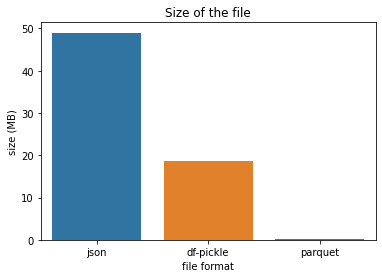

In [96]:
plot_dict(file_size,"file format", "size (MB)", "Size of the file")

In [119]:
print(f'The {min_size} format is {"{:.2f}".format(percentage_size)}% lighter than the {max_size} format.')

The parquet format is 99.39% lighter than the json format.


# Number of rows

In order to perform operations over the data. The following aproach are taken:
- Operate over the python list for json data (Search over the .json is not a practical aproach and will take more time)
- Operate over the pandas dataframe for .pkl file.
- Operate ever a pyarrow table for .parquet file.

In [98]:
json_data = read_json()
df_data = pd.read_pickle("./raw_data.pkl")
parquet_data = pq.read_table('./data_mintic.parquet')

In [99]:
%%timeit -o
len(json_data)

71.7 ns ± 5.13 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


<TimeitResult : 71.7 ns ± 5.13 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)>

In [100]:
time_row_json = _
print(time_row_json.average)

7.174899344265993e-08


In [103]:
%%timeit -o
df_data.shape[0]

822 ns ± 34.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<TimeitResult : 822 ns ± 34.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>

In [104]:
time_row_df = _
print(time_row_df.average)

8.218416074274241e-07


In [113]:
%%timeit -o
parquet_data.num_rows

49.4 ns ± 1.69 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


<TimeitResult : 49.4 ns ± 1.69 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)>

In [114]:
time_row_parquet = _
print(time_row_parquet.average)

4.940700587155464e-08


In [116]:
time_count = store_results(time_row_json.average*pow(10,9),time_row_df.average*pow(10,9),time_row_parquet.average*pow(10,9))
max_count, min_count, percentage_count = analyze_dict(time_count)

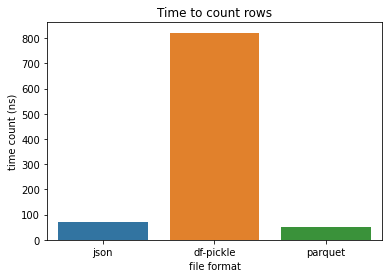

In [117]:
plot_dict(time_count,"file format", "time count (ns)", "Time to count rows")

In [118]:
print(f'The {min_count} format is {"{:.2f}".format(percentage_count)}% faster than the {max_count} format.')

The parquet format is 93.99% faster than the df-pickle format.


# Obtain a random element

In [120]:
random_index = random.randint(0,len(df_data))

In [122]:
%%timeit -o
json_data[random_index]

47.8 ns ± 1.81 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


<TimeitResult : 47.8 ns ± 1.81 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)>

In [123]:
time_random_json = _
print(time_random_json.average)

4.775379048556455e-08


In [124]:
%%timeit -o
df_data.iloc[random_index]

69.9 µs ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 69.9 µs ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [125]:
time_random_df = _
print(time_random_df.average)

6.986971975753217e-05


In [126]:
%%timeit -o
parquet_data.take([random_index])

68.1 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 68.1 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [127]:
time_random_parquet = _
print(time_random_parquet.average)

6.811153211414681e-05


In [128]:
time_random = store_results(time_random_json.average*pow(10,6),time_random_df.average*pow(10,6),time_random_parquet.average*pow(10,6))
max_random, min_random, percentage_random = analyze_dict(time_random)

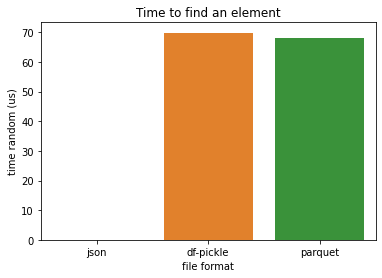

In [129]:
plot_dict(time_random,"file format", "time random (us)", "Time to find an element")

In [130]:
print(f'The {min_random} format is {"{:.2f}".format(percentage_random)}% faster than the {max_random} format.')

The json format is 99.93% faster than the df-pickle format.


### Comments

- Parquet file is around 90% faster to save and read, that allow better usability and disponibility of the data.
- Parquet file is a surprising 99% lighter than other formats, this provide to this format a huge advantage to store massive data in cloud systems at low cost.
- However, to perform basic operation with the data, the standard library not provide useful functions. Libraries like Pandas are useful to manage and operate this data.


## Send data to Mongo Atlas

Setup mongodb cluster, don forget add your DATABASE_URI as an environment variable according to your connection URI. See [mongo connect to your cluster](https://docs.atlas.mongodb.com/tutorial/connect-to-your-cluster/)

In [7]:
from pymongo import MongoClient

In [8]:
client = MongoClient(os.environ['DATABASE_URI'])

In [9]:
db = client['platzimaster']

In [11]:
mintic_collection = db['mintic']

Send the data to the mongo cluster.
**NOTE** Due to the number of register this process can take a lot of time (hours).

In [36]:
def insert_applicant(applicant_data):
    """
    Return a boolean value of an insert operation to a mongodb collection
    
    Parameters:
        applicant_data(dict): Dictionary to be stored as a BJSON in mongodb
        
    Returns:
        True or False (bool) according to the result of the insert
    """
    try:
        mintic_collection.insert_one(applicant_data)
        return True
    except Exception as e:
        print("An exception occurred ::", e)
        return False

In [38]:
#coping the data to send
json_data_send = list(json_data)

#Loop to send all the data
while True:
    #List to stor the boolean results during the send process
    result = []
    for register in json_data_send:
        result.append(insert_applicant(register))
    
    unsended_registers = result.count(False)
    if unsended_registers == 0:
        print("All data sended")
        break
        
    print(f'Unsended registers: {unsended_registers}')
    
    json_data_send = [json_data_send[x] for x in result if x == False]
    
    

All data sended


Counting the number of register

In [132]:
%timeit mintic_collection.count_documents({})

218 ms ± 53.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
mintic_collection.find_one({})

{'_id': ObjectId('6073b32f062d953d8e6eb4e2'),
 'fecha_corte': '2020-09-15',
 'departame_nombre': 'TOLIMA',
 'municipio_nombre': 'IBAGUE',
 'estado_formacion': 'ASPIRANTE',
 'estados': 'ASPIRANTES',
 'convocatoria': '1',
 'estrato_social': '3',
 'edad': '24',
 'genero': 'FEMENINO',
 'ruta': 'RUTA 2',
 'grado': '-1',
 'meta_beneficiario': '5623',
 'inversion': '946611',
 'meta_dinero': '5322791851',
 'fecha_vigencia': '2020-09-15'}

### Comments

- MongoDB is a useful database to store Json files, allowing disponibility using cluster that can scale.
- Manage large amounts of data require tools that optimize the time to store and manage data, such as parallel processing or asincronic process.